In [17]:
#Import Packages
#Requires Python 3.10 or earlier
import py_wake
import numpy as np
import matplotlib.pyplot as plt
import math

from py_wake import NOJ

<xarray.DataArray (sector: 12)> Size: 96B
array([0.06, 0.04, 0.04, 0.04, 0.05, 0.08, 0.12, 0.17, 0.18, 0.06, 0.06,
       0.1 ])
Coordinates:
  * sector   (sector) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

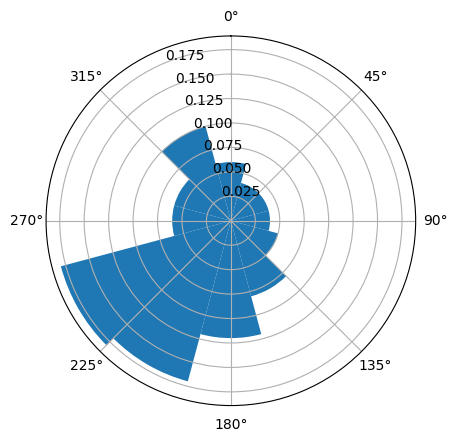

In [18]:
#Define Site
from py_wake.site import UniformWeibullSite
# Dummy offshore site object
wd = np.arange(0, 360, 30)
A = np.full_like(wd, 9.5, dtype=float) # Weibull scale parameter
k = np.full_like(wd, 2.0, dtype=float) # Weibull shape parameter

p_wd = np.array([0.06, 0.04, 0.04, 0.04, 0.05, 0.08, 0.12, 0.17, 0.18, 0.06, 0.06, 0.1], dtype=float) # sector frequencies (defines wind direction)
p_wd /= p_wd.sum()

site = UniformWeibullSite(p_wd=p_wd, a=A, k=k, ti=0.08) # Create uniform weibull site
site.plot_wd_distribution(n_wd=12) # Plot wind rose

****Wind turbine specifications****

Power and Thrust coefficient (Ct) curves:


"\nwt = WindTurbine(name='MyWT',\n                    diameter=124,\n                    hub_height=320,\n                    powerCtFunction=PowerCtTabular(u,power,'kW',thrust_coeff))\n\nor \n\nwt = GenericWindTurbine('G10MW', 180, 120, power_norm=10000, turbulence_intensity=.1)\n\nSource: https://www.pythonpool.com/pywake-library/\n"

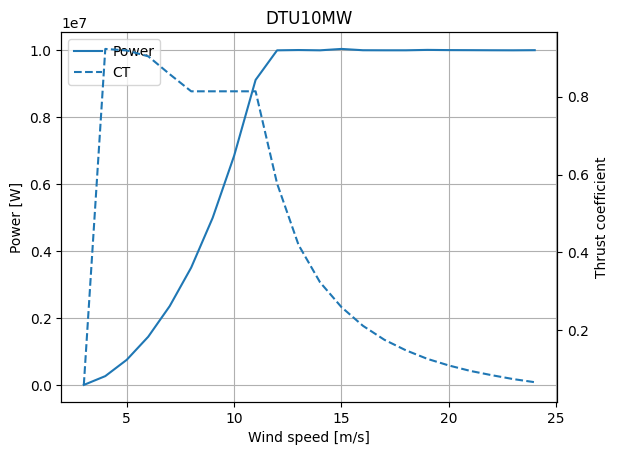

In [19]:
#Define Turbine
from py_wake.wind_turbines import WindTurbines
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import numpy as np

diameter = 204 #Turbine blade diameter in m
hub_height = 127 #Hub height in m

wt = DTU10MW() #Example 10mw turbine https://backend.orbit.dtu.dk/ws/portalfiles/portal/55645274/The_DTU_10MW_Reference_Turbine_Christian_Bak.pdf

#Plot Data
print('****Wind turbine specifications****\n')
print("Power and Thrust coefficient (Ct) curves:")
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
wt.plot_power_ct(ws=ws)

'''
wt = WindTurbine(name='MyWT',
                    diameter=124,
                    hub_height=320,
                    powerCtFunction=PowerCtTabular(u,power,'kW',thrust_coeff))

or 

wt = GenericWindTurbine('G10MW', 180, 120, power_norm=10000, turbulence_intensity=.1)

Source: https://www.pythonpool.com/pywake-library/
'''

In [20]:
#Define Turbine layout

# number of turbines in each direction:
n_x = 4
n_y = 5

rotor_diameter = diameter
dist_x = 4 * rotor_diameter
dist_y = 4 * rotor_diameter

# This defines the turbine positions
wt_x, wt_y = np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y)
wt_x = wt_x.flatten()
wt_y = wt_y.flatten()

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

n_wts = n_x * n_y


In [21]:
#Define Engineering windfarm model
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
windFarmModel = Bastankhah_PorteAgel_2014(site, wt, k=0.0324555)

Total AEP: 724.965386 GWh


Text(0.5, 1.0, 'AEP vs wind direction')

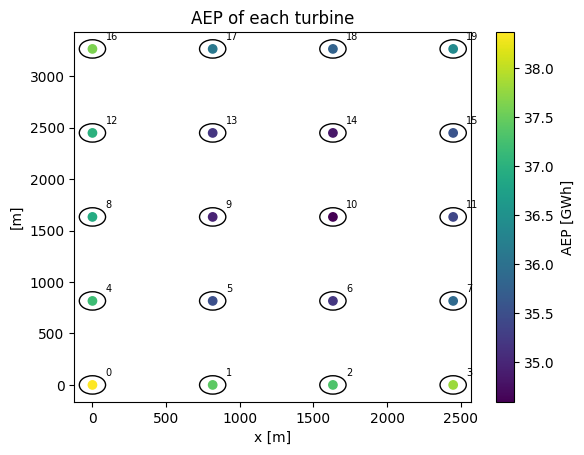

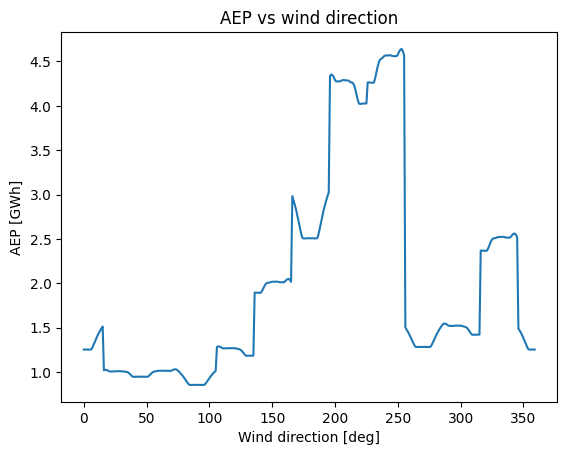

In [22]:
#Calculate AEP (Annual Energy Production)
from py_wake import NOJ

#import the wake deficit model
noj = NOJ(site,wt)
simulationResult = noj(wt_x,wt_y)

#Display Results
print ("Total AEP: %f GWh"%simulationResult.aep().sum())

plt.figure()
aep = simulationResult.aep() 
wt.plot(wt_x,wt_y)
c =plt.scatter(wt_x, wt_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

Text(0.5, 1.0, 'Wake map for 9 m/s and 225 deg')

<Figure size 640x480 with 0 Axes>

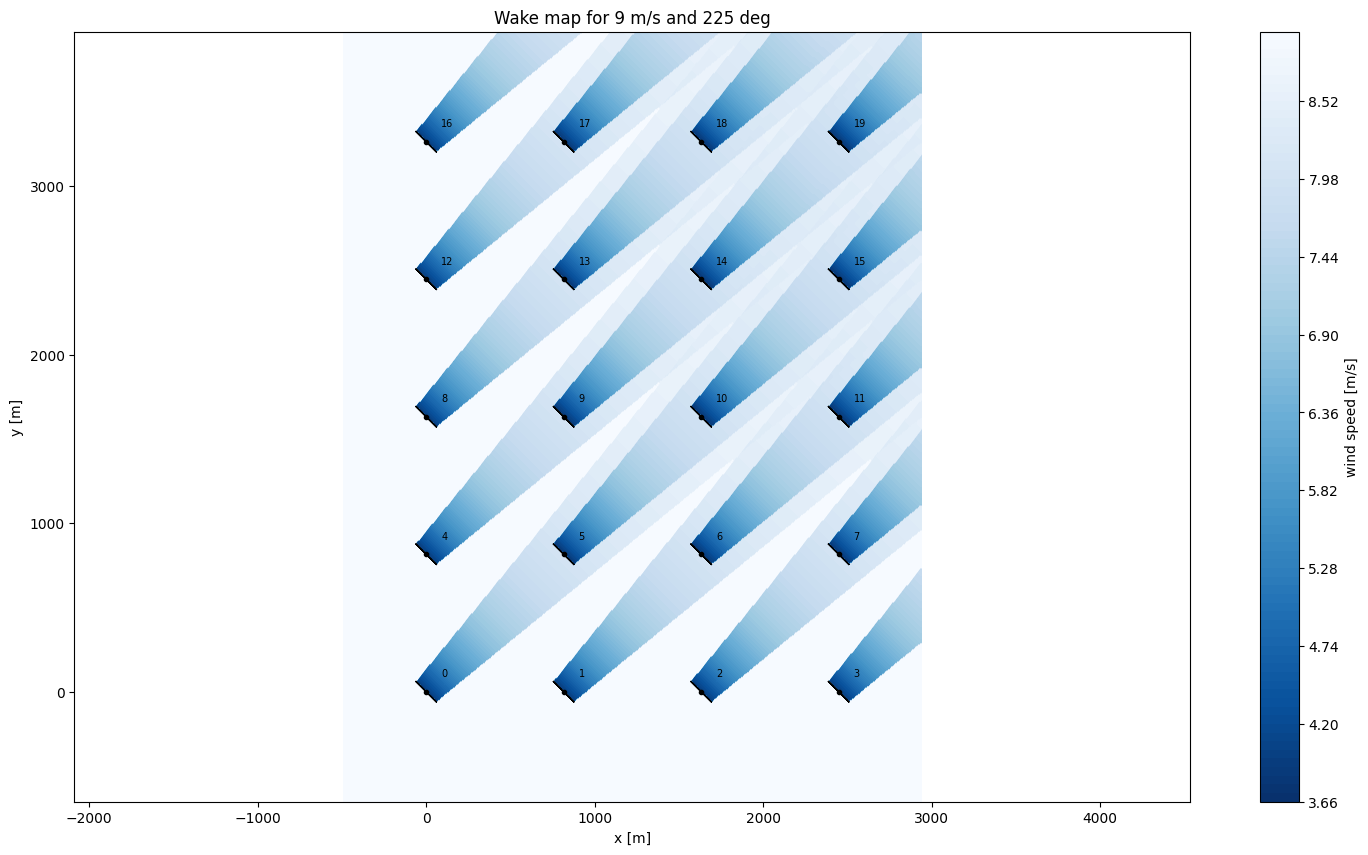

In [27]:
#Plot Flow Map
wind_speed = 9
wind_direction = 225

plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for' + f' {wind_speed} m/s and {wind_direction} deg')

Iteration limit reached    (Exit mode 9)
            Current function value: -745.929036266435
            Iterations: 500
            Function evaluations: 712
            Gradient evaluations: 499
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	448.632s


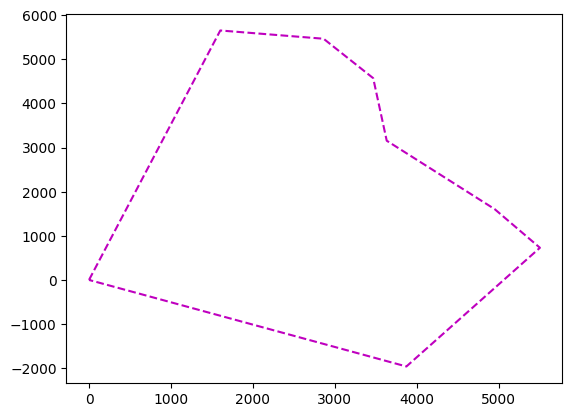

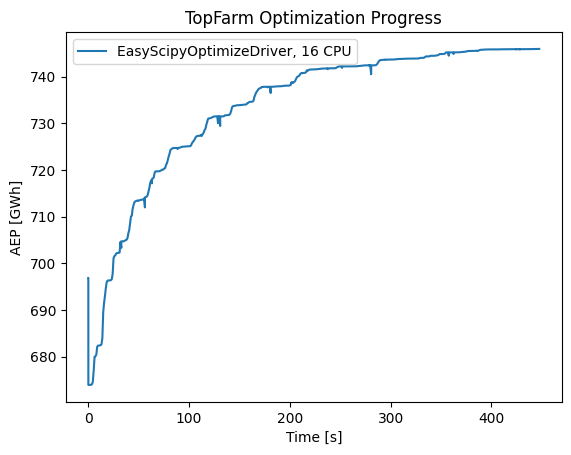

Optimization terminated successfully    (Exit mode 0)
            Current function value: -746.1516993789094
            Iterations: 42
            Function evaluations: 80
            Gradient evaluations: 42
Optimization Complete
-----------------------------------
Optimized in	39.664s


In [ ]:
# --- TopFarm imports ---
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver as fd

#Converstions between degrees on earth and m
def m2d_lat(m):
    return m / 111000

def m2d_lon(m, lat_deg):
    return m / (111000 * math.cos(math.radians(lat_deg)))

def d2m_lat(d):
    return d * 111000

def d2m_lon(d, lat_deg):
    return d * (111000 * math.cos(math.radians(lat_deg)))
'''
boundry_longLat = [
    (1.981910,56.921167),
    (1.974451,56.919002),
    (1.966039,56.911034),
    (1.964135,56.899420),
    (1.968893,56.888238),
    (1.985715,56.877331),
    (1.992857,56.878285),
    (1.992222,56.886262),
    (2.001586,56.893891),
    (1.989365,56.914342)
]
'''

boundry_longLat = [
    (2.044477,56.822299),
    (2.018068,56.873226),
    (1.997297,56.871540),
    (1.987327,56.863495),
    (1.984623,56.850720),
    (1.962953,56.836754),
    (1.953877,56.828867),
    (1.980750,56.804633)
]


boundary = [[0] for _ in range(len(boundry_longLat))] # Pre-allocate space for boundry in m

for b in range(len(boundry_longLat)):
    relative_long = boundry_longLat[0][0] - boundry_longLat[b][0]
    boundary[b][0] = d2m_lon(relative_long, boundry_longLat[b][1])

    relative_lat = boundry_longLat[b][1] - boundry_longLat[0][1]
    boundary[b].append(d2m_lat(relative_lat))
    #print(boundary[b][0],",",boundary[b][1])

#Split boundary into seperate x and y for plotting
bound_x = [p[0] for p in boundary] + [boundary[0][0]]
bound_y = [p[1] for p in boundary] + [boundary[0][1]]

#Plot Boundary
plt.figure()
plt.plot(bound_x,bound_y,"m--")

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

x0, y0 = np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y)
x0 = x0.flatten() 
y0 = y0.flatten()
def get_topfarmProblem_xy(wfm, x, y, grad_method, maxiter, n_cpu):
    
    farm_boundary = np.array(boundary)
    boundary_constr = XYBoundaryConstraint( 
        farm_boundary,
        boundary_type='polygon' 
    )

    return TopFarmProblem(
        design_vars={'x': x, 'y': y},
        cost_comp=PyWakeAEPCostModelComponent(
            windFarmModel=wfm,
            n_wt=len(x),
            grad_method=None,
            wd=wfm.site.default_wd,
            ws=wfm.site.default_ws
        ),
        driver=fd(maxiter=maxiter),
        constraints=[
            boundary_constr,
            SpacingConstraint(min_spacing=2 * wfm.windTurbines.diameter())
        ]
    )


def optimize_and_plot(wfm, x0, y0, maxiter):
    method = fd
    n_cpu = 16

    tf = get_topfarmProblem_xy(wfm, x0, y0, method, maxiter, n_cpu)
    cost, state, recorder = tf.optimize(disp=True)

    t, aep = [recorder[v] for v in ['timestamp', 'AEP']]
    plt.figure()
    plt.plot(t - t[0], aep, label=f'{method.__name__}, {n_cpu} CPU')
    plt.xlabel("Time [s]")
    plt.ylabel("AEP [GWh]")
    plt.title("TopFarm Optimization Progress")
    plt.legend()
    plt.show()
    return tf, cost, state, recorder


# --- Run optimization ---
tf, cost, state, recorder = optimize_and_plot(windFarmModel, x0, y0, maxiter=500)
#cost, state, recorder = tf.optimize(disp=True)


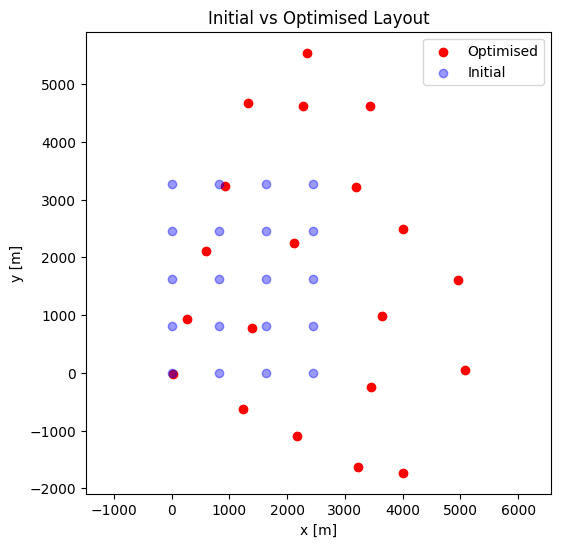

Turbine Locations in M
[[25.678949346339575, -13.002030531761465], [2171.0531309011485, -1099.2705510776145], [3224.872863591189, -1632.8513902778554], [4012.612035596599, -1730.1632855265216], [263.1055224129757, 928.4117606105308], [1241.2892826653056, -628.502707205537], [3446.881318653559, -239.52016319324758], [5085.85200450705, 41.466216896143266], [597.1535427732922, 2107.157481414771], [1389.1452007055002, 784.317842266387], [2118.8875706492454, 2250.979422800722], [4951.091724669927, 1602.9821817310437], [918.8600726946389, 3242.3548534311103], [3184.9676161372377, 3215.9642579039287], [3635.7350911672925, 978.3889878192771], [4000.1320881047013, 2490.360466758231], [1323.571767184554, 4670.450139282608], [2334.966640568938, 5544.038870225405], [2278.997355711776, 4613.280066132201], [3429.5042603998936, 4629.029792930161]]
Turbine Locations in degrees
[[56.82218186458981, -2.0440542563945305], [56.812395661702006, -2.0087450417796995], [56.80758862711461, -1.9914077119724176]

Text(0.5, 1.0, 'Wake map for new layout with 9 m/s and 225 deg')

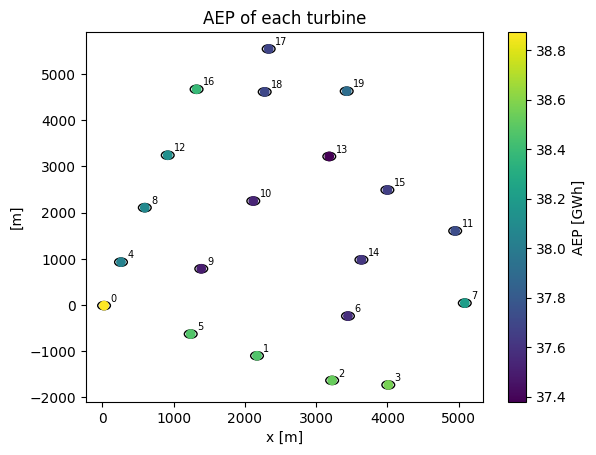

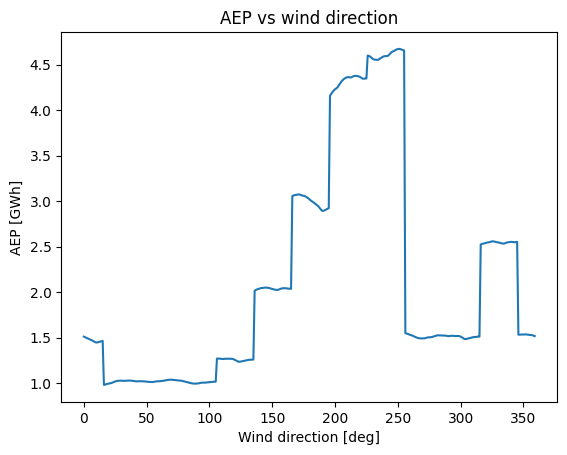

<Figure size 640x480 with 0 Axes>

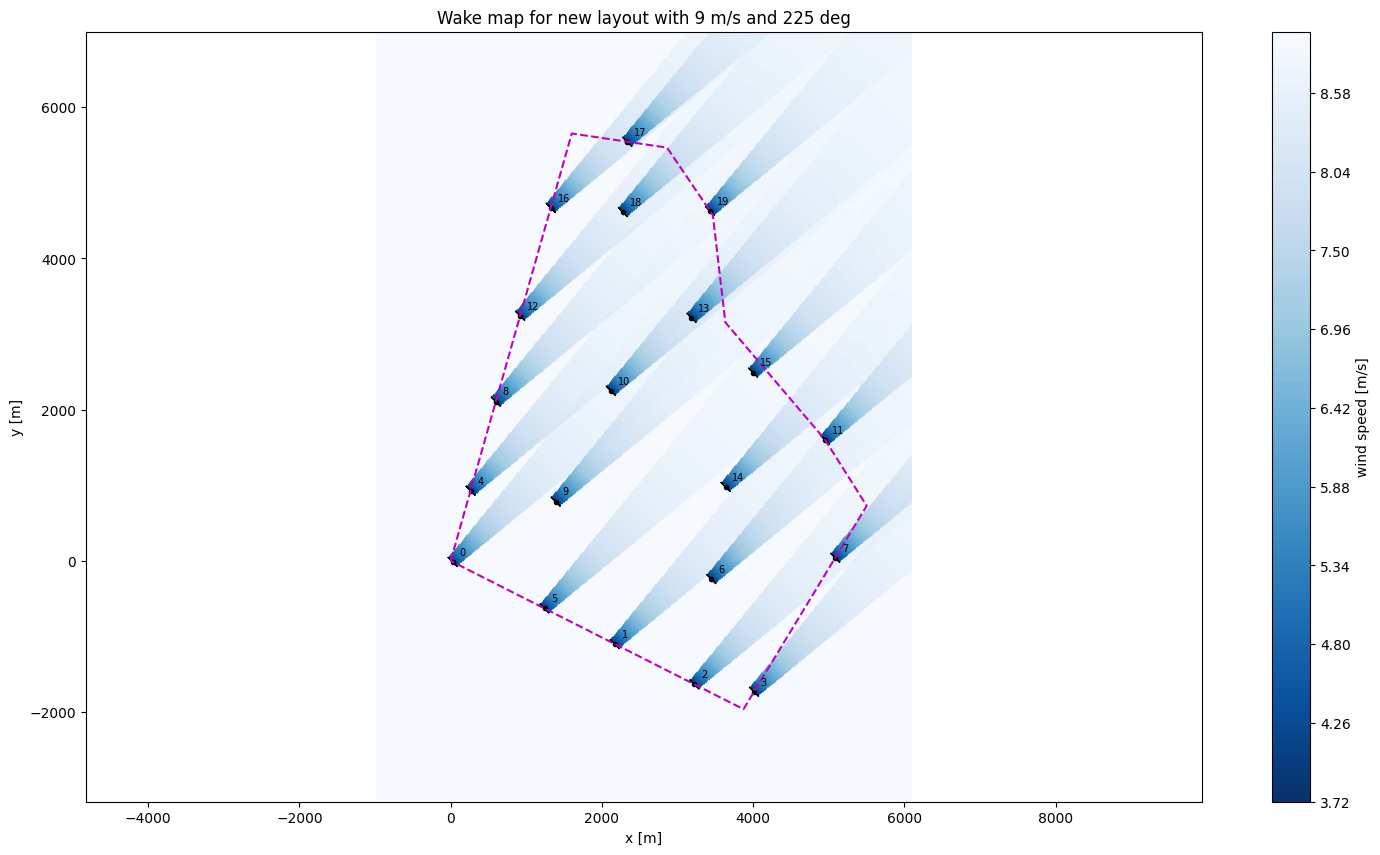

In [ ]:
# Plot results
plt.figure(figsize=(6,6))
plt.scatter(state['x'], state['y'], c='red', label='Optimised')
plt.scatter(x0, y0, c='blue', alpha=0.4, label='Initial')
plt.legend()
plt.title("Initial vs Optimised Layout")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.show()

#Define Engineering windfarm model for new layout
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
windFarmModelNew = Bastankhah_PorteAgel_2014(site, wt, k=0.0324555)

#import the wake deficit model
noj = NOJ(site,wt)
newSimulationResult = noj(x=state['x'],y=state['y'])

#Get coordinates of new locations and format into list
wt_x_locations=state['x']
wt_y_locations=state['y']
wt_xy_locations = [[0] for _ in range(len(wt_x_locations))] # Pre-allocate space for turbine locations in m

#Get new turbine locations in M
for l in range(len(wt_x_locations)):
    wt_xy_locations[l][0] = float(wt_x_locations[l])
    wt_xy_locations[l].append(float(wt_y_locations[l]))

print("Turbine Locations in M")
print(wt_xy_locations)

#Convert locations to lat and long
wt_lat_long_new = [[0] for _ in range(len(wt_x_locations))]
for t in range(len(wt_lat_long_new)):
    wt_lat_long_new[t][0] = m2d_lat(wt_xy_locations[t][1]) + boundry_longLat[0][1]
    wt_lat_long_new[t].append(m2d_lon(wt_xy_locations[t][0],wt_lat_long_new[t][0]) + boundry_longLat[0][0] * (-1))

print("Turbine Locations in degrees")
print(wt_lat_long_new)

#Display Results for new simulation
print("Total AEP: %f GWh"%newSimulationResult.aep().sum())

plt.figure()
aep = newSimulationResult.aep() 
wt.plot(x=state['x'],y=state['y'])
c =plt.scatter(x=state['x'],y=state['y'], c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plotName = "AEP of Turbines " + str(n_x) + " x " + str(n_y) + " starting spacing " + str(dist_x) + "in x and" + str(dist_y)
plt.title(plotName)
plt.xlabel('x [m]')
plt.ylabel('[m]')
plt.savefig(plotName)

plt.figure()
aep.sum(['wt','ws']).plot()
plotName = "AEP vs wind direction " + str(n_x) + " x " + str(n_y) + " spacing " + str(dist_x) + "in x and" + str(dist_y)
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')
plt.savefig(plotName)

#Plot Flow Map for new layout

plt.figure()
flow_map_new = newSimulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map_new.plot_wake_map()
plt.plot(bound_x, bound_y, 'm--')
plotName = "Turbine Layout " + str(n_x) + " x " + str(n_y) + " spacing " + str(dist_x) + "in x and" + str(dist_y)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for new layout with' + f' {wind_speed} m/s and {wind_direction} deg')
plt.savefig(plotName)